let us import library on demand

## Dataset

In [209]:
import os

In [210]:
dataset_path = os.path.join(
  os.getcwd(),
  '../datasets/',
  '50-startups',
  '50_Startups.csv'
)
dataset_path

'/home/anderson/Documents/ai-student/topics/2-ml-algos/1-supervised/../datasets/50-startups/50_Startups.csv'

In [211]:
import pandas as pd

In [212]:
dataset = pd.read_csv(dataset_path)
dataset.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [213]:
round(dataset.describe(), 2)

,R&D Spend,Administration,Marketing Spend,Profit
count,50.00,50.00,50.00,50.00
mean,73721.62,121344.64,211025.10,112012.64
std,45902.26,28017.80,122290.31,40306.18
min,0.00,51283.14,0.00,14681.40
25%,39936.37,103730.88,129300.13,90138.90
50%,73051.08,122699.80,212716.24,107978.19
75%,101602.80,144842.18,299469.08,139765.98
max,165349.20,182645.56,471784.10,192261.83


## Normalization

In [214]:
dataset.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

normalization not required

## Encode

In [215]:
def encode(dataset, columns):
  copy = dataset.copy()

  for column in columns:
    uniques = list(copy[column].unique())
    for i in range(copy.shape[0]):
      copy.loc[i, column] = uniques.index(copy[column][i])

  return copy, uniques

In [216]:
encoded = encode(dataset, ['State'])[0]
encoded.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,0,192261.83
1,162597.70,151377.59,443898.53,1,191792.06
2,153441.51,101145.55,407934.54,2,191050.39
3,144372.41,118671.85,383199.62,0,182901.99
4,142107.34,91391.77,366168.42,2,166187.94


# Scaling

In [217]:
def scale_all_columns(dataset):
  scale_map = {}

  copy = dataset.copy()

  for col in copy.columns:
    scale = {
      'min': copy[col].min(),
      'max': copy[col].max()
    }
    scale['diff'] = scale['max'] - scale['min']
    copy[col] = (copy[col] - scale['min']) / scale['diff']

    scale_map[col] = scale

  return copy, scale_map

In [218]:
scaled, scale_map = scale_all_columns(encoded)
scaled.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,1.000000,0.651744,1.000000,0.0,1.000000
1,0.983359,0.761972,0.940893,0.5,0.997355
2,0.927985,0.379579,0.864664,1.0,0.993178
3,0.873136,0.512998,0.812235,0.0,0.947292
4,0.859438,0.305328,0.776136,1.0,0.853171


## Split

In [219]:
train_size = 0.8
test_size = 0.2

In [220]:
output_column = 'Profit'
input_columns = scaled.columns.drop(output_column)

X = scaled[input_columns]
Y = scaled[output_column]

In [221]:
import numpy as np

In [222]:
def train_test_split(X, Y, train_size, test_size=None):
  X = np.array(X)
  Y = np.array(Y)
  
  train_size = train_size or 1 - test_size
  n = X.shape[0]

  train_size = int(n * train_size)

  return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

In [223]:
X_Train, Y_Train, X_Test, Y_Test = train_test_split(X, Y, train_size, test_size)

In [224]:
X_Train.shape, Y_Train.shape, X_Test.shape, Y_Test.shape

((40, 4), (40,), (10, 4), (10,))

## Hyper-Parameters

In [225]:
import numpy as np

In [226]:
learning_rate = 0.01
iterations = 1000
initial_weights = np.zeros(X.shape[1])

In [227]:
def gradient_decent(X, Y, weights, iterations_count, learning_rate, verbose=0):
  for _ in range(iterations_count):

    if verbose > 0:
      print(f"ITER = {_}, weights = {weights}")
      
    for row_idx in range(X.shape[0]):
      pred = np.dot(X[row_idx], weights)
      error = pred - Y[row_idx]
      for col_idx in range(X.shape[1]):
        weights[col_idx] -= error * learning_rate * X[row_idx][col_idx]

      if verbose > 1:
        print(f"sample = {row_idx}, error = {error}, weights = {weights}")


  return weights


In [228]:
def multi_linear_regression(X_Train, Y_Train, X_Test, Y_Test, initial_weights, iterations=1000, learning_rate=0.01, verbose=0):

  trained_weights = gradient_decent(
    X_Train,
    Y_Train,
    initial_weights,
    iterations,
    learning_rate,
    verbose
  )
  
  Y_Predicted = []
  for row_idx in range(X_Test.shape[0]):
    Y_Predicted.append(np.dot(X_Test[row_idx], trained_weights))

  return Y_Predicted
  
  

In [229]:
Y_Predicted = multi_linear_regression(
  X_Train,
  Y_Train,
  X_Test,
  Y_Test,
  initial_weights,
  iterations,
  learning_rate,
)

## Un-Scale

In [230]:
def unscale(y, map):
  for i in range(len(y)):
    y[i] = y[i] * (map['max'] - map['min']) + map['diff']
  return y

In [231]:
Y_Predicted_Unscaled = unscale(Y_Predicted, scale_map['Profit'])
Y_Predicted_Unscaled

[232976.7572129908,
 228767.20926724828,
 222195.87160280396,
 208684.62988480064,
 223357.6256430516,
 193912.15205481913,
 225896.6052518302,
 199666.25929284474,
 178098.21910254945,
 199577.45600717855]

In [232]:
Y_Test_Unscaled = unscale(Y_Test, scale_map['Profit'])
Y_Test_Unscaled

array([241138.94, 240697.86, 234397.52, 232658.01, 228099.36, 227825.11,
       212389.78, 205458.76, 198572.44, 177580.43])

## Metrics

In [233]:
def errors(Y_True, Y_Pred):
  # mean absolute error
  def mae(y_true, y_pred):
    n = len(y_true)
    return sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n

  # mean squared error
  def mse(y_true, y_pred):
    n = len(y_true)
    return sum((y_true[i] - y_pred[i])**2 for i in range(n)) / n
  
  return {
    'mae': mae(Y_True, Y_Pred),
    'mse': mse(Y_True, Y_Pred),
  }

In [234]:
errors(Y_Test_Unscaled, Y_Predicted_Unscaled)

{'mae': 15669.312719790007, 'mse': 322418786.1159522}

In [235]:
def scores(Y_True, Y_Pred, k):

  # R Square
  def r_square(y_true, y_pred):
    n = len(y_true)
    y_mean = sum(y_true) / n
    
    ss_tot = 0
    for num in y_true:
      ss_tot += (num - y_mean) ** 2
    
    ss_res = 0
    for i in range(n):
      ss_res += (y_true[i] - y_pred[i]) ** 2

    return 1 - (ss_res / ss_tot)
  
  r2 = r_square(Y_True, Y_Pred)

  return {
    'r2': r2,
    'adj_r2': 1 - ((1 - r2) * (Y_True.shape[0] - 1)) / (Y_True.shape[0] - k - 1)
  }
  
  # Adjusted R Square

In [236]:
scores(Y_Test_Unscaled, Y_Predicted_Unscaled, X_Test.shape[1])

{'r2': 0.17273060994221934, 'adj_r2': -0.48908490210400535}

## Visualization

In [238]:
import matplotlib.pyplot as plt

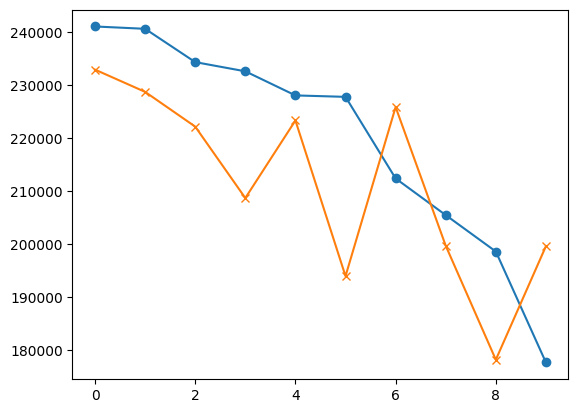

In [239]:
x = np.arange(len(Y_Test))

plt.plot(x, Y_Test_Unscaled, label='Actual', marker='o')
plt.plot(x, Y_Predicted_Unscaled, label='Predicted', marker='x')